Project 2 - Part 1
INFOTC 3040
Binary Classification Neural Network

Import modules

In [9]:
import numpy as np
import math
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.regularizers import l2

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

Load Data File using pandas

In [10]:
def loadData(filename):
    return pd.read_excel(filename)

rawShoppingData = loadData("shopping_data.xlsx")

Convert all of the data to number format

In [11]:
stringConverter = {
    "Month": {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "June": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    },

    "VisitorType": {
        "New_Visitor": 2,
        "Returning_Visitor": 1,
        "Other": 3
    }
}

def cleanData(data):
    data['Month'] = data['Month'].map(stringConverter['Month']) 
    data['VisitorType'] = data['VisitorType'].map(stringConverter['VisitorType'])

    data['Weekend'] = data['Weekend'].astype(int)
    data['Revenue'] = data['Revenue'].astype(int)

    return data


cleanShoppingData = cleanData(rawShoppingData)

Scale the data using StandardScalar from scikit which is equivalent to Z-Score scaling

In [12]:
X = cleanShoppingData.iloc[:, :-1]  # All columns except the last one
y = cleanShoppingData.iloc[:, -1]   # The last column (Revenue)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Split the data into 60:20:20 using the train_test_split method from scikit

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42) 
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

# Print the shapes of the split datat to confirm no errors
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_cv.shape}, {y_cv.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (3000, 17), (3000,)
Validation set: (1000, 17), (1000,)
Test set: (1000, 17), (1000,)


Build the neural network using Keras Dense layers

In [14]:
def create_model(lamba, layer_units, _epoch, _batchsize, modelName):

    #initialize model
    model = Sequential(
        [tf.keras.Input(shape=(X_train.shape[1],)),],  
    ) 

    for u in layer_units:
        model.add(Dense(units=u, activation="relu", kernel_regularizer=l2(lamba)))

    model.add(Dense(units=1, activation="sigmoid")) #output layer

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    modelHistory = model.fit(
        X_train, y_train,
        validation_data=(X_cv, y_cv),
        epochs=_epoch,
        batch_size=_batchsize,
        verbose=0
    )

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"{modelName}\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return model, modelHistory


   

model, modelHistory = create_model(0.001, [32,16, 8], 40, 16, "Model 1")


Model 1
Test Loss: 0.3095, Test Accuracy: 0.8870


Calculate F1, Precision, and Recall

In [15]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  #convert probabilities to 0 or 1

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
#----
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Precision: 0.6696
Recall: 0.4967
F1-Score: 0.5703


Graph the loss on the training and test sets

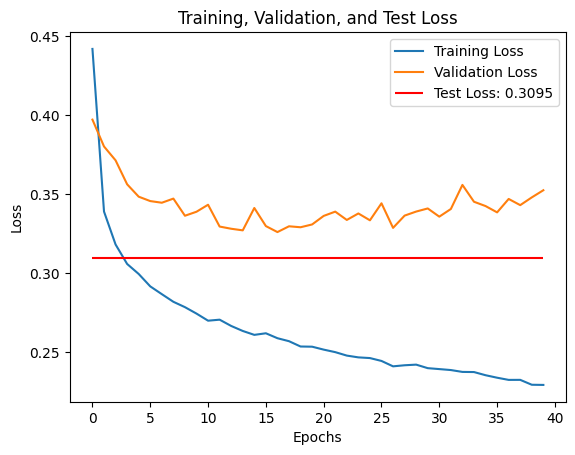

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

plt.plot(modelHistory.history['loss'], label='Training Loss')
plt.plot(modelHistory.history['val_loss'], label='Validation Loss')

plt.hlines(test_loss, xmin=0, xmax=len(modelHistory.history['loss'])-1, color='r', label=f'Test Loss: {test_loss:.4f}')

plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
